# Analyzing COVID-19 data

The notebook below has been created in a hurry, no guarantee at all. Doublecheck all computations etc. before 

The data is dynamically imported from https://raw.githubusercontent.com/CSSEGISandData

Read their terms of use! Last time I checked it, it is strictly for public use in academic or research purposes.

## Import data

In [114]:
import pandas as pd

raw_types = [ "Confirmed", "Recovered", "Deaths" ]

raw_urls = {}
raw_urls["Confirmed"] = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
raw_urls["Recovered"] = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv"
raw_urls["Deaths"] = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv"

raw_df = {}
for raw_type in raw_types:
    raw_df[raw_type] = pd.read_csv(raw_urls[raw_type])

Let's have a look which province/states and countries/regions are included. Only a part of the list is shown.

In [115]:
raw_df[raw_types[0]][~pd.notnull(raw_df[raw_types[0]]['Province/State'])]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,50,53,59,70,75,82,114,147,177,212
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,511,581,639,639,701,773,839,825,878,889
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,150,160,178,178,200,212,226,243,266,313
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,117,129,149,149,197,238,428,566,673,790
9,NaN,Cambodia,11.5500,104.9167,0,0,0,0,0,1,...,2,2,3,3,5,7,7,7,33,35
10,NaN,Sri Lanka,7.0000,81.0000,0,0,0,0,0,1,...,1,1,2,2,6,10,18,28,44,51
11,NaN,Germany,51.0000,9.0000,0,0,0,0,0,1,...,1176,1457,1908,2078,3675,4585,5795,7272,9257,12327
12,NaN,Finland,64.0000,26.0000,0,0,0,0,0,0,...,30,40,59,59,155,225,244,277,321,336
13,NaN,United Arab Emirates,24.0000,54.0000,0,0,0,0,0,0,...,45,74,74,85,85,85,98,98,98,113


# Adaptation

Via the following list you can adapt which countries to be analyzed. 

Note: For some countries (e.g. China, United States), the input data is further decomposed into provinces/states. These countries are not yet supported here.

In [116]:
countries = [ 'Germany', 'Italy', 'Iran', 'Austria', 'Spain' ]

Check that all countries have accociated data.

In [117]:
remove_states = raw_df[raw_types[0]][~pd.notnull(raw_df[raw_types[0]]['Province/State'])]
for country in countries:    
    filtered = remove_states.loc[remove_states['Country/Region'].eq(country)]
    if (filtered.empty):
        raise ValueError("Country "+country+" not found in input data.")           

Special treatment of specific countries which are decomposed into provinces/states.

In [118]:
raw_df[raw_types[0]]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,50,53,59,70,75,82,114,147,177,212
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,511,581,639,639,701,773,839,825,878,889
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,150,160,178,178,200,212,226,243,266,313
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,117,129,149,149,197,238,428,566,673,790
5,British Columbia,Canada,49.2827,-123.1207,0,0,0,0,0,0,...,32,32,39,46,64,64,73,103,103,186
6,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,...,48,55,65,65,92,112,134,171,210,267
7,Victoria,Australia,-37.8136,144.9631,0,0,0,0,1,1,...,15,18,21,21,36,49,57,71,94,121
8,Queensland,Australia,-28.0167,153.4000,0,0,0,0,0,0,...,15,18,20,20,35,46,61,68,78,94
9,NaN,Cambodia,11.5500,104.9167,0,0,0,0,0,1,...,2,2,3,3,5,7,7,7,33,35


In [119]:
decomposed_countries = {}

# Use first 52 entries as list of states in US
us_states = raw_df[raw_types[0]][raw_df[raw_types[0]]['Country/Region']=='US'][:52]
decomposed_countries['US'] = us_states['Province/State'].tolist()

# decomposed_countries['US']
uk_states = raw_df[raw_types[0]][raw_df[raw_types[0]]['Country/Region']=='United Kingdom']
decomposed_countries['United Kingdom'] = uk_states['Province/State'].tolist()

## Convert Data

In [120]:
def extract_values(df, country):
    filtered = df[~pd.notnull(df['Province/State']) & df['Country/Region'].eq(country)]
    transposed = filtered.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1).transpose()
    values = transposed[transposed.columns[0]]
    return values

dates = raw_df[raw_types[0]].drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1).transpose().index.tolist()

# Get data for countries
all = {}
for country in countries:
    data = {}
    for raw_type in raw_types:
        values = extract_values(raw_df[raw_type], country)
        data[raw_type] = values
    all[country] = pd.DataFrame(data, index=dates)

In [121]:
def extract_values_with_region(df, country, region):
    filtered = df[df['Province/State'].eq(region) & df['Country/Region'].eq(country)]
    transposed = filtered.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1).transpose()
    values = transposed[transposed.columns[0]]
    return values

dates = raw_df[raw_types[0]].drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1).transpose().index.tolist()
ext_countries = countries

# Get data for states/regions with associated countries
for dcountry in decomposed_countries:
    sub = {}
    df1 = pd.DataFrame(data=0, index=dates, columns=raw_types)            
    first = True
    for region in decomposed_countries[dcountry]:
        data = {}
        for raw_type in raw_types:
            values = extract_values_with_region(raw_df[raw_type], dcountry, region)            
            df1[raw_type] = df1[raw_type] + values 
    all[dcountry] = df1
    ext_countries.append(dcountry)
    
all["US"].tail(10)

,Confirmed,Recovered,Deaths
3/9/20,66,0,0
3/10/20,959,8,28
3/11/20,1281,8,36
3/12/20,1663,12,40
3/13/20,2174,12,47
3/14/20,2717,12,54
3/15/20,3478,12,63
3/16/20,4594,17,85
3/17/20,6372,17,108
3/18/20,7725,0,118


Show intermediate data.

In [122]:
all[countries[len(countries)-1]].tail(10)

,Confirmed,Recovered,Deaths
3/9/20,322,18,4
3/10/20,384,19,6
3/11/20,459,19,8
3/12/20,459,19,8
3/13/20,802,19,8
3/14/20,1144,19,21
3/15/20,1145,19,21
3/16/20,1551,21,56
3/17/20,1960,53,56
3/18/20,2642,67,72


In [123]:
all[countries[0]].tail(10)

,Confirmed,Recovered,Deaths
3/9/20,1176,18,2
3/10/20,1457,18,2
3/11/20,1908,25,3
3/12/20,2078,25,3
3/13/20,3675,46,7
3/14/20,4585,46,9
3/15/20,5795,46,11
3/16/20,7272,67,17
3/17/20,9257,67,24
3/18/20,12327,105,28


## Enrich data

Enrich by computing Active = Confirmed - (Recovered + Deaths)

In [124]:
for country in ext_countries:
    all[country]["Active"] = all[country]["Confirmed"] - (all[country]["Recovered"] + all[country]["Deaths"])

raw_types_ext = raw_types.copy()
raw_types_ext.append("Active")

Enrich by computing the rate and moving average on rate.

In [125]:
def addRate(df, label):
    df[label+" Rate"] = df[label].pct_change()
    
def addMovAverage(df, label, window_size):
    df[label+" Avg"] = df[label].rolling(window=window_size,center=False).mean()

window_size = 6
for country in ext_countries:
    for raw_type in raw_types_ext:
        addRate(all[country], raw_type)
        addMovAverage(all[country], raw_type+" Rate", window_size)

Show part of final data.

In [126]:
all[countries[0]].tail(10)

,Confirmed,Recovered,Deaths,Active,Confirmed Rate,Confirmed Rate Avg,Recovered Rate,Recovered Rate Avg,Deaths Rate,Deaths Rate Avg,Active Rate,Active Rate Avg
3/9/20,1176,18,2,1156,0.130769,0.365234,0.000000,0.020221,inf,NaN,0.131115,0.382996
3/10/20,1457,18,2,1437,0.238946,0.348936,0.000000,0.020221,0.000000,NaN,0.243080,0.362398
3/11/20,1908,25,3,1880,0.309540,0.260577,0.388889,0.085035,0.500000,NaN,0.308281,0.264727
3/12/20,2078,25,3,2050,0.089099,0.210420,0.000000,0.074619,0.000000,NaN,0.090426,0.212916
3/13/20,3675,46,7,3622,0.768527,0.306418,0.840000,0.204815,1.333333,NaN,0.766829,0.308052
3/14/20,4585,46,9,4530,0.247619,0.297417,0.000000,0.204815,0.285714,NaN,0.250690,0.298404
3/15/20,5795,46,11,5738,0.263904,0.319606,0.000000,0.204815,0.222222,0.390212,0.266667,0.320995
3/16/20,7272,67,17,7188,0.254875,0.322261,0.456522,0.280902,0.545455,0.481121,0.252701,0.322599
3/17/20,9257,67,24,9166,0.272965,0.316165,0.000000,0.216087,0.411765,0.466415,0.275181,0.317082
3/18/20,12327,105,28,12194,0.331641,0.356589,0.567164,0.310614,0.166667,0.494193,0.330351,0.357070


## Plot data

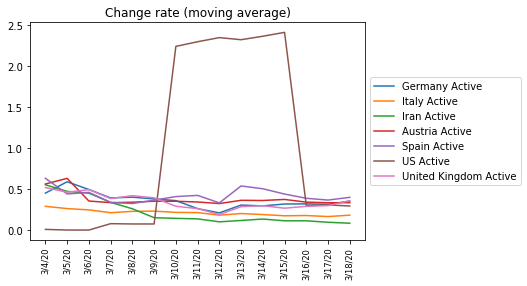

In [127]:
import matplotlib.pyplot as plt
import numpy as np

number_of_days = 15

for country in ext_countries:
    ts = all[country]["Active Rate Avg"].tail(number_of_days)
    pl = ts.plot(label=country+" Active")
    
    # Uncomment the following to add all lines in one figure
    #cl = plt.gca().lines[-1].get_color()    
    #ts = all[country]["Deaths Rate Avg"].tail(number_of_days)
    #ts.plot(label=country+" Deaths", linestyle='dashed', color=cl)

plt.title("Change rate (moving average)")
plt.xticks(np.arange(number_of_days), all[country].tail(number_of_days).index.tolist(), 
           fontsize='small', rotation='vertical')
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


The y-axis shows the daily growth in percentage, e.g. 0.4 means that 40% more cases have been reported.

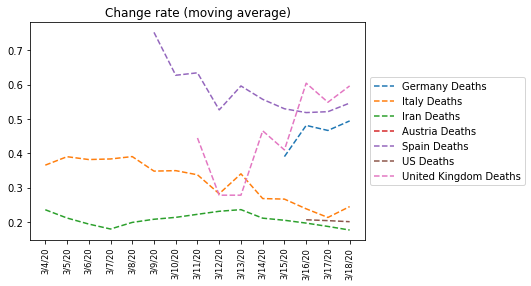

In [ ]:
for country in ext_countries:
    ts = all[country]["Deaths Rate Avg"].tail(number_of_days)
    ts.plot(label=country+" Deaths", linestyle='dashed')
    
plt.title("Change rate (moving average)")
plt.xticks(np.arange(number_of_days), all[country].tail(number_of_days).index.tolist(), 
           fontsize='small', rotation='vertical')
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Diagram per Country

In [ ]:
for country in ext_countries:
    ts = all[country]["Active Rate Avg"].tail(number_of_days)
    pl = ts.plot(label=country+" Active")
    
    # Get color of last plot
    cl = plt.gca().lines[-1].get_color()
    
    ts = all[country]["Deaths Rate Avg"].tail(number_of_days)
    ts.plot(label=country+" Deaths", linestyle='dashed', color=cl)

    plt.title("Change rate (moving average)")
    plt.xticks(np.arange(number_of_days), all[country].tail(number_of_days).index.tolist(), 
               fontsize='small', rotation='vertical')

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()